TODO
- label smoothing

# Boilerplate

In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
# more configs for training are defined later
TRAINING_DIRECTORY = '../data/preprocessed_stories'
EXTENSION = '.clean'
N_TRAIN_FILES = 100_000
N_TEST_FILES = 500
# TOKENS_PER_BATCH = 4096
TOKENS_PER_BATCH = 1_000
BPE_MODEL_FILE = 'summarizer_10000.model'
BPE_VOCAB_FILE = 'summarizer_10000.vocab'

In [3]:
# # show tensor2tensor hparams for summarization for reference
# import tensor2tensor.models.transformer
# from tensor2tensor.utils.registry import hparams
# params = hparams('transformer_prepend')()
# for k, v in sorted(vars(params).items(), key=lambda tup: tup[0]):
#     if not k.startswith('_') and not callable(v):
#         print(f'{k}={v!r}')

# Read in files

In [4]:
import glob

In [5]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES[:10]

311971


['../data/preprocessed_stories/8bea156c50b9bb04ef1804a13971c381e63b790f.clean',
 '../data/preprocessed_stories/96f71e32fad9bfef59c4a67b021609cf86b126de.clean',
 '../data/preprocessed_stories/50a945a090973a747082435b6f4bfd1da7922ad6.clean',
 '../data/preprocessed_stories/0e2569c383c66c3491f16029af147019d79a2480.clean',
 '../data/preprocessed_stories/17c1d1ff679615f250f545750a3fa7feddc9a9ca.clean',
 '../data/preprocessed_stories/7471e1359d1b9e0440d948ee116089b109d005c3.clean',
 '../data/preprocessed_stories/b7470294d56d294e4fd9801f190ae92352e1216a.clean',
 '../data/preprocessed_stories/021d78038eef6d680537762a51963f514059ea97.clean',
 '../data/preprocessed_stories/debcabe9677c446e3fbb8851f225cb30d38beea6.clean',
 '../data/preprocessed_stories/b2fcb5fce5937b69c882a09151ba83c084fa4ad4.clean']

In [6]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

# Initialize Tokenizer

In [7]:
import numpy as np
import sentencepiece as spm

class BytePairEncoder:
    def __init__(self, vocab_size, model_name, *, model_file=None, vocab_file=None,
                 training_file=None, processor=None, **kwargs):
        self.vocab_size = vocab_size
        self.model_name = model_name
        self.training_file = training_file
        self.model_file = f'{self.model_name}.model' if model_file is None else model_file
        self.vocab_file = f'{self.model_name}.vocab' if vocab_file is None else vocab_file
        if processor is None:
            if training_file is None:
                raise ValueError('training_file cannot be None when processor is also None.')
            processor = self._fit(input=training_file, vocab_size=vocab_size,
                                  model_prefix=model_name, model_type='bpe',
                                  **kwargs)
        self.processor = processor
        
    def encode(self, text):
        return np.array(self.processor.EncodeAsIds(text))
    
    def encode_as_pieces(self, text):
        return self.processor.EncodeAsPieces(text)
    
    def decode(self, ids):
        return self.processor.DecodeIds(ids.tolist())
    
    def decode_pieces(self, pieces):
        return self.processor.DecodePieces(pieces)

    @classmethod
    def from_files(cls, model_file, vocab_file):
        model_name = model_file.partition('.')[0]
        processor = cls._load_model(model_file)
        for vocab_size, _ in enumerate(open(vocab_file), start=1): pass
        return cls(vocab_size=vocab_size, model_name=model_name, processor=processor,
                   model_file=model_file, vocab_file=vocab_file)
        
    @staticmethod
    def _load_model(filename):
        processor = spm.SentencePieceProcessor()
        processor.Load(filename)
        return processor
        
    def _fit(self, **kwargs):
        params = ' '.join([f'--{k}={v}' for k, v in kwargs.items()])
        spm.SentencePieceTrainer.Train(params)
        processor = self._load_model(self.model_file)
        return processor

In [8]:
# convenience function - decoding an unkown token breaks sentencepiece
def decode(arr, pad_token, decoder):
    valid_tokens = iter(arr[arr != pad_token])
    output = []
    for pad in (arr == pad_token):
        output.append('<pad>' if pad else decoder(np.array([next(valid_tokens)])))
    print(len(output))
    return ' '.join(output)

In [9]:
# trained in byte-pair-encoding
TOKENIZER = BytePairEncoder.from_files(BPE_MODEL_FILE, BPE_VOCAB_FILE)

In [10]:
TOKENIZER.vocab_size

10000

# Tokenize files

In [11]:
class TrainingExample:
    """Simple container to keep track of training data. Useful for debugging."""
    def __init__(self, item, context_text, target_text, context_tokens,
                 target_tokens, filename):
        self.item = item
        self.context_text = context_text
        self.target_text = target_text
        self.context_tokens = context_tokens
        self.target_tokens = target_tokens
        self.filename = filename
        
    def __len__(self):
        return len(self.context_tokens) + len(self.target_tokens)

def load_files(files, encoder):
    """Load and tokenize files."""
    training_examples = []
    for file in files:
        with open(file) as f:
            context_text, target_text = f.read().split('\t')
        context_tokens = encoder(context_text)
        target_tokens = encoder(target_text)
        example = TrainingExample(file, context_text, target_text,
                                  context_tokens, target_tokens,
                                  file)
        training_examples.append(example)
    return training_examples

In [12]:
%%time
from tqdm import tqdm_notebook as tqdm
TRAINING_EXAMPLES = load_files(tqdm(TRAIN_FILES), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
TRAINING_EXAMPLES = sorted(TRAINING_EXAMPLES, key=lambda x: len(x))


CPU times: user 3min 27s, sys: 3.23 s, total: 3min 31s
Wall time: 3min 33s


In [13]:
len(TRAINING_EXAMPLES[0]), len(TRAINING_EXAMPLES[-1]), np.median([len(example) for example in TRAINING_EXAMPLES])

(55, 4263, 913.0)

In [14]:
looky = iter(TRAINING_EXAMPLES)

In [15]:
example = next(looky)
print(example.filename)
print('CONTEXT TEXT')
print(example.context_text)
print('\nTARGET TEXT')
print(example.target_text)
print('\nCONTEXT TOKENS (DECODED)')
print(TOKENIZER.decode(example.context_tokens))
print('\nTARGET TOKENS (DECODED)')
print(TOKENIZER.decode(example.target_tokens))

../data/preprocessed_stories/86bd905861391cbd3a98de15c83768b6d1400304.clean
CONTEXT TEXT
Congressman Jared Polis

(D) Colorado: District 02

Congressman Jason Chaffetz

(R) Utah: District 03

TARGET TEXT
Two freshman representatives document their experience for CNN. Rep. Jared Polis is a Democrat representing Colorado's Second district.

CONTEXT TOKENS (DECODED)
Congressman Jared Polis (D) Colorado: District 02 Congressman Jason Chaffetz (R) Utah: District 03

TARGET TOKENS (DECODED)
Two freshman representatives document their experience for CNN. Rep. Jared Polis is a Democrat representing Colorado's Second district.


# Take a look at batches

In [16]:
import numpy as np
from data import BaseBatchGenerator
from keras.preprocessing.sequence import pad_sequences


class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, max_context_len=None, max_target_len=None, pad_token=0,
                 bos_token=1, eos_token=2, prepend=False):
        self.max_context_len = max_context_len
        self.max_target_len = max_target_len
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.prepend = prepend

    def generate_steps(self, item):
        example = item  # alias
        if self.max_target_len is not None \
                and len(example.target_tokens) > self.max_target_len:
            training_step = []
        else:
            # get encoder tokens.
            if self.max_context_len is not None:
                encoder_tokens = example.context_tokens[:self.max_context_len]
            else:
                encoder_tokens = example.context_tokens
            # get decoder tokens.
            # start with a pad to account for offsetting the decoder input from
            # the output tokens
            decoder_tokens = np.array([self.pad_token])
            if self.prepend:
                decoder_tokens = np.append(decoder_tokens, example.context_tokens)
                decoder_tokens = np.append(decoder_tokens, self.eos_token)
            decoder_tokens = np.append(decoder_tokens, example.target_tokens)
            decoder_tokens = np.append(decoder_tokens, self.eos_token)
            training_step = [(encoder_tokens, decoder_tokens, len(example))]
        return training_step

    def generate_batches(self, steps, batch_size):
        batches = []
        min_batch_size = 0.95 * batch_size
        max_batch_size = 1.05 * batch_size
        step_sizes = [size for _, _, size in steps]
        current_batch_x1s = []
        current_batch_x2s = []
        items = enumerate(zip(steps, step_sizes, step_sizes[1:]))
        max_used_i = -1
        for i, (step, step_size, next_step_size) in items:
            if step_size > max_batch_size:
                continue
            encoder_tokens, decoder_tokens, _ = step
            current_batch_x1s.append(encoder_tokens)
            current_batch_x2s.append(decoder_tokens)
            next_batch_size = (len(current_batch_x1s) + 1) * next_step_size  # account for padding
            if next_batch_size > max_batch_size:
                max_used_i = i
                x1 = pad_sequences(current_batch_x1s, value=self.pad_token, padding='post')
                x2 = pad_sequences(current_batch_x2s, value=self.pad_token, padding='post')
                X = [x1, x2[:,:-1]]
                y = x2[:,1:]
                batches.append((X, y))
                current_batch_x1s, current_batch_x2s = [], []
            # if there aren't enough steps left to create a full sized batch
            # then break, the leftover steps will be added to the next call
            # to generate_batches()
            if sum(step_sizes[i+1:]) < batch_size:
                break
        return (batches, steps[max_used_i+1:]) if max_used_i >= 0 else (batches, steps)


Using TensorFlow backend.


In [17]:
BATCH_GENERATOR = SummaryBatchGenerator(pad_token=TOKENIZER.vocab_size, prepend=True)

In [18]:
epoch_generator = BATCH_GENERATOR.generate_epoch(TRAINING_EXAMPLES, batch_size=TOKENS_PER_BATCH)

In [19]:
%time epoch = list(epoch_generator)

CPU times: user 2min 43s, sys: 556 ms, total: 2min 43s
Wall time: 2min 43s


In [20]:
len(epoch)

53523

In [21]:
sum(x1.shape[0] for (x1, x2), y in epoch), len(TRAINING_EXAMPLES)

(61310, 100000)

In [22]:
# TOOD: if we skip a training example because it is too large or if steps
#       are "leftover" because they aren't big enough for a batch this will fail
#       
# assert sum(x1.shape[0] for (x1, _), _ in epoch) == len(TRAINING_EXAMPLES), \
#    'number of steps in batch does not equal number of examples'

In [23]:
def view_training_steps(x1, x2, y):
    print('ENCODER INPUT')
    print(decode(x1, 10_000, TOKENIZER.decode))
    print('\n')
    print('DECODER INPUT')
    print(decode(x2, 10_000, TOKENIZER.decode))
    print('\n')
    print('OUTPUT')
    print(decode(y, 10_000, TOKENIZER.decode))

In [24]:
np.random.shuffle(epoch)
views = (view_training_steps(x1[0], x2[0], y[0]) for (x1, x2), y in epoch)

In [25]:
next(views)

ENCODER INPUT
491
By Step h C ock ro ft A her d of c ows was spotted mar aud ing through a sleep y village and into residents ' front g ard ens after myster iously esc aping from a field in a quiet S uff olk village . Police had to help round up the L on gh orn ste ers , c attle and cal ves after they sa un tered through the streets of Re y don , near the se as ide resort of South w old , S uff olk , early on Sunday morning . Commun ity nurse Cath y Ryan , 5 7, jumped out of bed after hearing the c ows ' bell owing ' outside her home and managed to co ax them back into a field . C ows were seen str oll ing through the streets of the tiny village Re y don , near South w old , S uff olk , early on Sunday morning The group of L on gh orn ste ers , c attle and cal ves charged through people ' s g ard ens during their str oll She said : ' I am used to w aking up to the d awn ch or us . But I thought I was dream ing when I heard c ows bel l owing outside my bedroom window at 5 am on a Sunday

In [26]:
(x1, x2), y = epoch[0]
print(x1.shape, x2.shape)
(x1, x2), y = epoch[-1]
print(x1.shape, x2.shape)

(1, 491) (1, 534)
(1, 892) (1, 958)


In [27]:
x1.shape, x2.shape

((1, 892), (1, 958))

In [28]:
import collections

class LazyAverage:
    def __init__(self):
        self.v = 0
        self.n = 0
        
    def __add__(self, other):
        self.v += other
        self.n += 1
        return self
        
    def __repr__(self):
        return str(self.v / self.n)

def calc_stats(epoch, pad_token, unkown_token):
    stats = collections.defaultdict(int)
    averages = collections.defaultdict(LazyAverage)
    for (x1, x2), y in epoch:
        stats['x1_tok'] += ((x1 != pad_token) & (x1 != unkown_token)).sum()
        stats['x1_pad'] += (x1 == pad_token).sum()
        stats['x1_unk'] += (x1 == unkown_token).sum()
        stats['x2_tok'] += ((x2 != pad_token) & (x2 != unkown_token)).sum()
        stats['x2_pad'] += (x2 == pad_token).sum()
        stats['x2_unk'] += (x2 == unkown_token).sum()
        averages['x1_avg_seq_len'] += x1.shape[-1]
        averages['x1_avg_pad'] += (x1 == pad_token).sum()
        averages['x1_avg_unk'] += (x1 == unkown_token).sum()
        averages['x2_avg_seq_len'] += x2.shape[-1]
        averages['x2_avg_pad'] += (x2 == pad_token).sum()
        averages['x2_avg_unk'] += (x2 == unkown_token).sum()
    return stats, averages
calc_stats(epoch, BATCH_GENERATOR.pad_token, 0)

(defaultdict(int,
             {'x1_tok': 40375872,
              'x1_pad': 67117,
              'x1_unk': 73742,
              'x2_tok': 42721814,
              'x2_pad': 61616,
              'x2_unk': 76352}),
 defaultdict(__main__.LazyAverage,
             {'x1_avg_seq_len': 703.8401061226015,
              'x1_avg_pad': 1.2539842684453413,
              'x1_avg_unk': 1.3777628309324963,
              'x2_avg_seq_len': 742.9981503278964,
              'x2_avg_pad': 1.1512060235786485,
              'x2_avg_unk': 1.426526913663285}))

## Build final training generator
now that we're happy with the batch generator create one that goes forever

In [29]:
# for debugging
LAST_ITEM = collections.deque([None], maxlen=1)
def generate_forever(items):
    while True:
        for item in items:
            LAST_ITEM.append(item)
            yield item
        print('exhausted `items`, repeating')

In [30]:
TRAIN_GEN = generate_forever(epoch)

In [31]:
LAST_ITEM

deque([None])

# Training

## Define functions for loss/metrics/callbacks

In [32]:
import tensorflow as tf
import keras.backend as K

# on custom implementation rather than keras see
# https://github.com/tensorflow/tensorflow/issues/17150
def sparse_categorical_crossentropy(y_true, y_pred):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                             logits=y_pred)
    return entropy

def sparse_entropy(y_true, y_pred):
    # why do I have to do this?
    return K.log(K.exp(sparse_categorical_crossentropy(y_true, y_pred)))

def perplexity(y_true, y_pred):
    return K.exp(sparse_categorical_crossentropy(y_true, y_pred))

In [33]:
import numpy as np

# see
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/learning_rate.py
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps, learning_rate):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.epoch = 1
        self.initial_lr = self.lr()

    def lr(self, *args):
        scalar = 5000 \
               * self.d_model**-0.5 \
               * min(self.epoch * self.warmup_steps**-1.5, self.epoch**-0.5)
        self.epoch += 1
        return 0.002 * scalar * self.learning_rate

## Define validation set

In [ ]:
# %%time
VALIDATION_EXAMPLES = load_files(tqdm(TEST_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
VALIDATION_EXAMPLES = sorted(VALIDATION_EXAMPLES, key=lambda x: len(x))
TEST_EPOCH = list(BATCH_GENERATOR.generate_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH))
TEST_GEN = generate_forever(TEST_EPOCH)
N_VALIDATION_STEPS = BATCH_GENERATOR.batches_per_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH)

## Training configs

In [35]:
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler, TensorBoard

In [36]:
# # model architecture
N_HEADS = 8
N_LAYERS = 6
D_MODEL = 64*N_HEADS
SENTENCE_LEN = None
VOCAB_SIZE = TOKENIZER.vocab_size + 1  # +1 accounts for pad token
DROPOUT = 0.1
OUTPUT_ACTIVATION = 'linear'  # temporary workaround for keras bug - see above

# learning rate
WARMUP_STEPS = 32_000
LEARNING_RATE = 0.2
LEARNING_RATE_SCHEDULER = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)

# # optimization
# # https://arxiv.org/pdf/1804.00247.pdf
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-9
OPTIMIZER = adam(lr=LEARNING_RATE_SCHEDULER.initial_lr, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
METRICS = []
LOSS = sparse_entropy

# # batch training
N_EPOCHS = 30
N_TRAIN_STEPS = 10_000
CALLBACKS = [LearningRateScheduler(LEARNING_RATE_SCHEDULER.lr),
             TensorBoard(log_dir='./logs')]

## Training

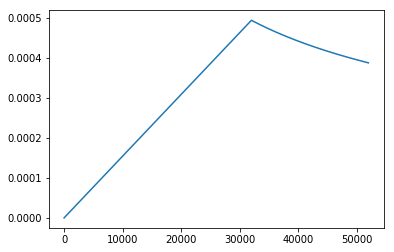

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
scheduler = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)
learning_rates = [scheduler.lr()
                  for _ in range(WARMUP_STEPS+20_000)]
plt.plot(learning_rates)

In [38]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    output_activation=OUTPUT_ACTIVATION)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_spec (InputLayer) (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input_spec (InputLayer) (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    5120512     encoder_input_spec[0][0]         
                                                                 decoder_input_spec[0][0]         
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, None, 512)    0           embedding[0][0]                  
          

In [40]:
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
#    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER],
)

In [41]:
# print loss values for reference
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

perplexity:    10001.00000000001	entropy:    9.210440366976517
perplexity:    8103.083927575384	entropy:                    9
perplexity:   2980.9579870417283	entropy:                    8
perplexity:   1096.6331584284585	entropy:                    7
perplexity:    403.4287934927351	entropy:                    6
perplexity:    148.4131591025766	entropy:                    5
perplexity:   54.598150033144236	entropy:                    4
perplexity:   20.085536923187668	entropy:                    3
perplexity:     7.38905609893065	entropy:                    2
perplexity:    2.718281828459045	entropy:                    1
perplexity:                  1.0	entropy:                    0


In [ ]:
# display entropy, perplexity reference
max_entropy = np.log(VOCAB_SIZE)
entropy = np.array(list(range(np.ceil(max_entropy))) + [max_entropy])
pd.DataFrame({'perplexity': np.exp(entropy), 'entropy': entropy})

In [ ]:
model.fit_generator(
    TRAIN_GEN,
    steps_per_epoch=N_TRAIN_STEPS,
    epochs=N_EPOCHS,
    validation_data=TEST_GEN,
    validation_steps=N_VALIDATION_STEPS,
    callbacks=CALLBACKS)

Epoch 1/30
10000/10000 [==============================] - 2816s 282ms/step - loss: 9.2026 - val_loss: 9.1749
Epoch 2/30
10000/10000 [==============================] - 2804s 280ms/step - loss: 9.1487 - val_loss: 9.1109
Epoch 3/30
10000/10000 [==============================] - 2806s 281ms/step - loss: 9.0869 - val_loss: 9.0453
Epoch 4/30
10000/10000 [==============================] - 2808s 281ms/step - loss: 9.0249 - val_loss: 8.9807
Epoch 5/30
10000/10000 [==============================] - 2806s 281ms/step - loss: 8.9640 - val_loss: 8.9178
Epoch 6/30
10000/10000 [==============================] - 2815s 281ms/step - loss: 8.9021 - val_loss: 8.8528
Epoch 7/30
10000/10000 [==============================] - 2812s 281ms/step - loss: 8.8358 - val_loss: 8.7813
Epoch 8/30
10000/10000 [==============================] - 2809s 281ms/step - loss: 8.7607 - val_loss: 8.7010
Epoch 9/30
10000/10000 [==============================] - 2815s 281ms/step - loss: 8.6759 - val_loss: 8.6099
Epoch 10/30
10000/1